# Analysis of the Mobile Games A/B Testing - Cookie Cats dataset

### **Table of contents**<a id='toc0_'></a>    
- 1. [Introduction](#toc1_)    
- 2. [Data preparation](#toc2_)    
  - 2.1. [Downloading the dataset and reviewing meta data](#toc2_1_)    
  - 2.2. [Loading the data](#toc2_2_)    
- 3. [Data cleaning](#toc3_)    
  - 3.1. [Setting data types](#toc3_1_)    
  - 3.2. [Describing the data](#toc3_2_)    
  - 3.3. [Handling missing values](#toc3_3_)    
  - 3.4. [Deduplication process](#toc3_4_)    
  - 3.5. [Outliers: identification and handling](#toc3_5_)    
    - 3.5.1. [Rule-based method](#toc3_5_1_)    
    - 3.5.2. [Statistical outliers](#toc3_5_2_)    
- 4. [A/B testing](#toc4_)    
  - 4.1. [Mission/Goal definition](#toc4_1_)    
  - 4.2. [Metrics definition](#toc4_2_)    
  - 4.3. [Calculations](#toc4_3_)    
    - 4.3.1. [Sanity check](#toc4_3_1_)    
    - 4.3.2. [Retention for 1 day](#toc4_3_2_)    
      - 4.3.2.1. [Proportion and Confidence interval](#toc4_3_2_1_)    
      - 4.3.2.2. [Hypothesis test and Effect size](#toc4_3_2_2_)    
    - 4.3.3. [Retention for 7 days](#toc4_3_3_)    
      - 4.3.3.1. [Proportion and Confidence interval](#toc4_3_3_1_)    
      - 4.3.3.2. [Additional task: Bootstrap Confidence interval](#toc4_3_3_2_)    
      - 4.3.3.3. [Hypothesis test and Effect size](#toc4_3_3_3_)    
  - 4.4. [Results and Decisions](#toc4_4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Introduction](#toc0_)

This project analyzes the impact of a game design change on user retention rates in the mobile game Cookie Cats. Specifically, it examines the effects of relocating the first gate in the game from level 30 to level 40 through an A/B testing approach. The goal was to assess how this change influenced player retention after Day 1 and Day 7 post-installation.

## 2. <a id='toc2_'></a>[Data preparation](#toc0_)

Import necessary libraries:

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

Hide warnings within jupyter notebook outputs:

In [2]:
{
    "tags": [
        "hide-input",
    ]
}
import warnings

warnings.simplefilter("ignore")

### 2.1. <a id='toc2_1_'></a>[Downloading the dataset and reviewing meta data](#toc0_)

Download the Mobile Games A/B Testing - Cookie Cats [here](https://www.kaggle.com/datasets/mursideyarkin/mobile-games-ab-testing-cookie-cats).

**Meta data** for the dataset:

***Context***

This dataset includes A/B test results of Cookie Cats to examine what happens when the first gate in the game was moved from level 30 to level 40. When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

***Content***

The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:

**userid**: A unique number that identifies each player.

**version**: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).

**sum_gamerounds**: the number of game rounds played by the player during the first 14 days after install.

**retention_1**: Did the player come back and play 1 day after installing?

**retention_7**: Did the player come back and play 7 days after installing?

### 2.2. <a id='toc2_2_'></a>[Loading the data](#toc0_)

In [3]:
df_orig = pd.read_csv("../data/cookie_cats.csv", index_col=0)
df = df_orig
df.shape

(90189, 4)

The dataset consists of 90_189 rows/datapoints and 5 columns/features. The `userid` is unique and each user has only one datapoint in the dataset. We can use it as the dataframe index.


Below we can get a quick look on the first 5 records and the columns:

In [4]:
df.sort_index().head()

,version,sum_gamerounds,retention_1,retention_7
userid,,,,
116,gate_30,3,False,False
337,gate_30,38,True,False
377,gate_40,165,True,False
483,gate_40,1,False,False
488,gate_40,179,True,True


## 3. <a id='toc3_'></a>[Data cleaning](#toc0_)

Before analysing the data, the data cleansing process must deal with setting the data type, handling missing values, deduplicating samples and characteristics and identifying and processing outliers.

### 3.1. <a id='toc3_1_'></a>[Setting data types](#toc0_)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90189 entries, 116 to 9999861
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   version         90189 non-null  object
 1   sum_gamerounds  90189 non-null  int64 
 2   retention_1     90189 non-null  bool  
 3   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(1), object(1)
memory usage: 2.2+ MB


The column *version* can be of data type `category` since they consist of a distinct list of categories (see below).

In [6]:
print(df["version"].value_counts())

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64


In [7]:
df["version"] = df["version"].astype("category")

### 3.2. <a id='toc3_2_'></a>[Describing the data](#toc0_)

There are 90.189 users/players in the dataset which are roughly equally assigned to the two experiment groups:

- **control group** (gate_30 - a gate at level 30):    44.700 user
- **experiment group** (gate_40 - a gate at level 40):    45.489 user


In [8]:
df["sum_gamerounds"].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

The total number of gamerounds played per user range from 0 to 49.854.

In [9]:
df["retention_1"].value_counts()

retention_1
False    50036
True     40153
Name: count, dtype: int64

40.153 player came back and played 1 day after installing.

In [10]:
df["retention_7"].value_counts()

retention_7
False    73408
True     16781
Name: count, dtype: int64

16.781 player came back and played 7 days after installing.

In [11]:
pd.crosstab(df["retention_1"], df["retention_7"])

retention_7,False,True
retention_1,,
False,46437,3599
True,26971,13182


In retention analysis, seeing a user marked as retained at 7 days but not at 1 day can happen due to data inconsistencies, measurement delays, or unexpected data recording issues. Here are some possible reasons:

1. **Data Inconsistencies**: If the retention data wasn't recorded at the exact same times or if there were errors in tracking, a user might be incorrectly flagged for 7-day retention while missing the 1-day retention flag.
  
2. **Re-engagement**: The user might not have engaged on the first day but returned later and continued using the product up to day 7. Some tracking systems allow for this type of re-engagement.

3. **Measurement Logic Differences**: There may be a gap or different criteria in how retention is recorded. For instance, if "1-day retention" is based on a specific action within 24 hours but "7-day retention" is broader, it could lead to this discrepancy.

To address it, checking the criteria for each retention variable and ensuring consistency in tracking logic would help clarify these cases.

### 3.3. <a id='toc3_3_'></a>[Handling missing values](#toc0_)

No missing values were detected (see 3.1), thus no handling is required.

### 3.4. <a id='toc3_4_'></a>[Deduplication process](#toc0_)

Looking at the indexed `userid` values we can confirm there are no duplicates:

In [12]:
df.index.is_unique

True

Thus, no further deduplication is required.

### 3.5. <a id='toc3_5_'></a>[Outliers: identification and handling](#toc0_)

Identifying outliers in the data follows a three step plan:
1) Using data visualization techniques to inspect the data’s distribution and verify the presence of outliers
2) Using a statistical method to calculate the outlier data points
3) Applying a statistical method to flag, drop or transform the outliers

Moreover, a two-level approach is applied to check both types of outliers, *natural* and *anomalous*: the rule-based method and the statistical approach. 

#### 3.5.1. <a id='toc3_5_1_'></a>[Rule-based method](#toc0_)

The decribed variables/columns did not reveal any unreasonable values.

#### 3.5.2. <a id='toc3_5_2_'></a>[Statistical outliers](#toc0_)

As next, the `sum_gamerounds` feature is visualized (via boxplot and histogram) to detect possible outliers:

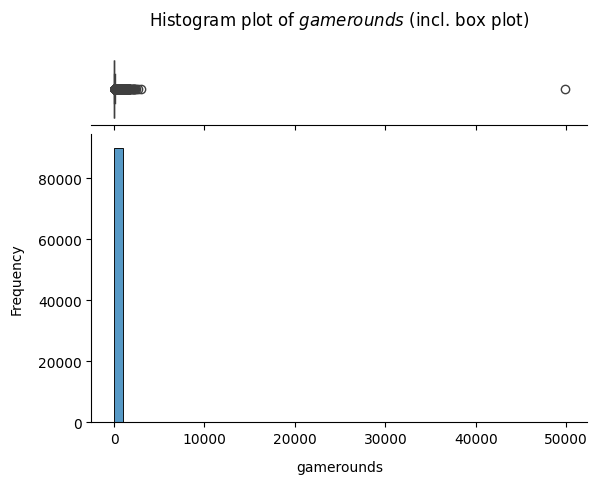

In [13]:
f, (ax_box, ax_hist) = plt.subplots(
    2, sharex=True, gridspec_kw={"height_ratios": (0.20, 0.80)}
)
sns.boxplot(x=df["sum_gamerounds"], ax=ax_box)
sns.histplot(x=df["sum_gamerounds"], bins=50, ax=ax_hist)

ax_box.set(yticks=[])
ax_hist.set_ylabel("Frequency", labelpad=10)
ax_hist.set_xlabel("gamerounds", labelpad=10)
ax_box.set_title(r"Histogram plot of $\it{gamerounds}$ (incl. box plot)", pad=20)
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
plt.subplots_adjust(hspace=0.05)
plt.show()

We can see from the histogram above that there is one extreme outlier with an unusually high number of gamerounds played. We want to exclude this datapoint from the dataset, since it looks obviously as a form of data corruption:

In [14]:
df = df[df["sum_gamerounds"] <= 10000]

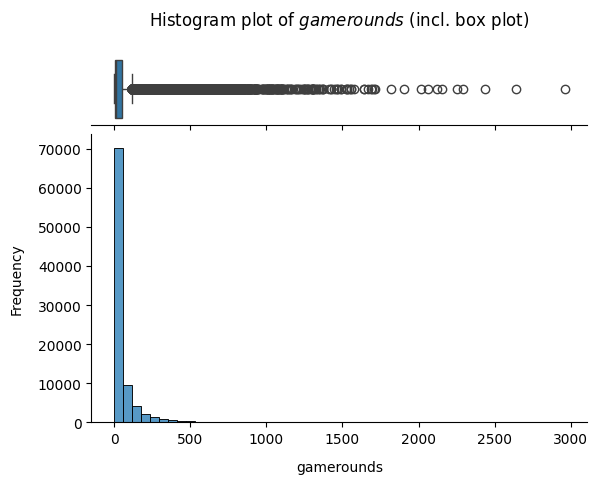

In [15]:
f, (ax_box, ax_hist) = plt.subplots(
    2, sharex=True, gridspec_kw={"height_ratios": (0.20, 0.80)}
)
sns.boxplot(x=df["sum_gamerounds"], ax=ax_box)
sns.histplot(x=df["sum_gamerounds"], bins=50, ax=ax_hist)

ax_box.set(yticks=[])
ax_hist.set_ylabel("Frequency", labelpad=10)
ax_hist.set_xlabel("gamerounds", labelpad=10)
ax_box.set_title(r"Histogram plot of $\it{gamerounds}$ (incl. box plot)", pad=20)
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
plt.subplots_adjust(hspace=0.05)
plt.show()

`Gamerounds` are exponentially distributed, with a long tail to the right, which is quite typical, especially in contexts where the rounds can end at any time and are not tied to a fixed, long-term engagement. In games, players often leave or "drop off" randomly. The exponential distribution is common for modeling the time until an event (like stopping play), where events happen independently and randomly over time. Players tend to start out with high engagement, trying a few rounds at the beginning. As time goes on, more players stop, leaving a smaller number who continue playing for many rounds. In many games, there’s a large number of players who only play a few rounds, while a small but committed group plays many rounds, creating a long tail in the distribution. This exponential decay is frequently observed in user behavior data, such as session lengths or retention rates, as players "churn" or lose interest over time.

The values range from 0 to 2.961 with a median average of 16 game rounds played per user:

In [16]:
df["sum_gamerounds"].describe()

count    90188.000000
mean        51.320253
std        102.682719
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

## 4. <a id='toc4_'></a>[A/B testing](#toc0_)

### 4.1. <a id='toc4_1_'></a>[Mission/Goal definition](#toc0_)

Based on the dataset description, the mobile games company tries to examine on A/B test results of the game Cookie Cats what happens when the first gate in the game was moved from level 30 (control group) to level 40 (experiment group). The players are randomly assigned to either group. The description suggests rather a exploratory analysis. However, given the dependent variables in the dataset, it suggest that the company aims to monitor and probably increase the **retention rate** (the percentage of player who continue to use the mobile game over a predetermined period). Therefore the mission/goal of the A/B test is ***to determine if moving the first gate in the game to level 40 increases the user retention rates (1 day and 7 days)***.

### 4.2. <a id='toc4_2_'></a>[Metrics definition](#toc0_)

The test can be understood as an A/B test, as it aims to compare the effect on user retention between a control (gate at level 30) and experiment group (gate at level 40). We utilize the two retention rates for 1 day and 7 days as a measure of success.

The **retention rate** is the proportion of customers who continue to use a service or product over a predetermined period. We want to compare the retention rate between the control and experiment group to determine if the intervention in the experiment group has a significant impact on user retention. We do this twice, independently from each other, for the retention for 1 and for 7 days, since the intervention can have different impacts on the user retention based on the predetermined period.

Therefore, the target metric for this analysis is the ***retention rate***.



### 4.3. <a id='toc4_3_'></a>[Calculations](#toc0_)

#### 4.3.1. <a id='toc4_3_1_'></a>[Sanity check](#toc0_)

In [17]:
counts = df.groupby("version", observed=False)["retention_1"].count()
counts.loc["Total"] = counts.sum()
counts

version
gate_30    44699
gate_40    45489
Total      90188
Name: retention_1, dtype: int64

 - Sample size: The total sample size of the experiment is the sum of the two variants, thus the 90.188 observations (users/players)
 - Variant proportions: The variants of the two groups are rather equal but the experiment group is with 45.489 players slightly larger than the control group with 44.699 players. Therefore we want to do a sanity check on the population sizing metric.

The Chi-square test is widely used for Sample Ratio Mismatch (SRM)  because it works well for categorical data with expected counts across multiple groups and is straightforward when comparing observed vs. expected distributions.


In [18]:
observed_counts = counts.iloc[:2]
total_players = sum(observed_counts)
expected_counts = [total_players / 2, total_players / 2]

chi2_stat, p_value = stats.chisquare(observed_counts, expected_counts)

print(f"Chi-square statistic: {chi2_stat:.04f}")
print(f"P-value: {p_value:.04f}")

Chi-square statistic: 6.9200
P-value: 0.0085


A p-value of 0.0085 indeed indicates a significant Sample Ratio Mismatch (SRM), which means that the split between the control and experiment groups likely differs more than expected from a random 50/50 distribution. This could have implications for the validity of our A/B test, as it may introduce bias or confounding factors. **Comparative statistics may be invalid as a result.**

However, given the large sample size, we can likely relax the strict balance assumption. In practice, such small differences in sample size will not drastically affect the overall findings of our A/B test. Random assignment doesn't guarantee exact balance but instead aims to make the groups similar overall, so even if there is a slight imbalance, the effect of random assignment should average out. In large samples, this imbalance is less likely to introduce significant bias. Furthermore, if the sample size is large, the Law of Large Numbers ensures that the imbalances due to randomness become less important in terms of influencing the outcome.


#### 4.3.2. <a id='toc4_3_2_'></a>[Retention for 1 day](#toc0_)

##### 4.3.2.1. <a id='toc4_3_2_1_'></a>[Proportion and Confidence interval](#toc0_)

In [19]:
contingency_table_ret_1 = (
    df.groupby("version", observed=False)["retention_1"]
    .value_counts()
    .unstack(fill_value=0)
)
counts = contingency_table_ret_1
counts["Total"] = counts.sum(axis=1)
counts.loc["Total"] = counts.sum()
counts

retention_1,False,True,Total
version,,,
gate_30,24665,20034,44699
gate_40,25370,20119,45489
Total,50035,40153,90188


In [20]:
proportions_ret_1 = (
    df.groupby("version", observed=False)["retention_1"]
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)
proportions_ret_1.loc["Total"] = df["retention_1"].value_counts(normalize=True)
proportions_ret_1

retention_1,False,True
version,,
gate_30,0.551802,0.448198
gate_40,0.557717,0.442283
Total,0.554786,0.445214


We can see from the contigency table above that the retention rate of the experiment group (gate_40) is with 44.22% in fact marginally lower than the control groups rate (44.81%).

Since we have a large sample size and the retention rate is not extremely small or large (near 0 or 1), we can rely on the normal approximation for calculating the confidence interval:
$$
CI = \hat{p} \pm Z \times \sqrt{\frac{\hat{p}(1 - \hat{p})}{n}}
$$
Where:
- $\hat{p}$  is the sample proportion (retention rate).
- $Z$ is the Z-score for the desired confidence level
- $n$ is the sample size.

We chose a 95% confidence level (alpha = 5%) whose Z-score is 1.96.

In [21]:
retention_rate_1 = df.groupby("version", observed=False)["retention_1"].agg(
    n="size", successes="sum"
)
retention_rate_1["retention_rate"] = (
    retention_rate_1["successes"] / retention_rate_1["n"]
)
Z = 1.96
retention_rate_1["se"] = np.sqrt(
    (retention_rate_1["retention_rate"] * (1 - retention_rate_1["retention_rate"]))
    / retention_rate_1["n"]
)
retention_rate_1["ci_lower"] = (
    retention_rate_1["retention_rate"] - Z * retention_rate_1["se"]
)
retention_rate_1["ci_upper"] = (
    retention_rate_1["retention_rate"] + Z * retention_rate_1["se"]
)
print(retention_rate_1)

             n  successes  retention_rate        se  ci_lower  ci_upper
version                                                                
gate_30  44699      20034        0.448198  0.002352  0.443588  0.452808
gate_40  45489      20119        0.442283  0.002329  0.437719  0.446847


We can see from the resulting boundaries of the confidence intervall (ci_lower, ci_upper) that with 95% confidence, the true population proportion for the control group is estimated to lie between 44.4% and 45.3%, while for the experiment group it is estimated to lie between 43.8% and 44.7%.

##### 4.3.2.2. <a id='toc4_3_2_2_'></a>[Hypothesis test and Effect size](#toc0_)

To test if the difference in retention proportions between the two versions is statistically significant, a **chi-square test of independence** is used. This test assesses whether there is a significant association between the version and the retention outcome (True/False). 

There are a few prerequirements for the chi-square test but these are all met in this case:
- The data should be in a frequency (count) format, often displayed in a contingency table, with each cell representing the count of observations that fall into each category combination 
- Each observation (e.g., each user’s retention status) should be independent of the others
- Sample Size and Expected Frequencies must be sufficiently large
- Both the grouping variable (e.g., control vs. experimental group) and the outcome variable (e.g., retained vs. not retained) should be categorical

Therefore we can run the test:

In [22]:
chi2, p, _, _ = stats.chi2_contingency(contingency_table_ret_1)
print(f"Chi-square statistic: {chi2:.04f}")
print(f"P-value: {p:.04f}")

Chi-square statistic: 3.1937
P-value: 0.5259


As already indicated by the marginally low difference in the retention rates, the high p-value of 0.5259 does not confirm a significant difference between both groups.

#### 4.3.3. <a id='toc4_3_3_'></a>[Retention for 7 days](#toc0_)

##### 4.3.3.1. <a id='toc4_3_3_1_'></a>[Proportion and Confidence interval](#toc0_)

In [23]:
contingency_table_ret_7 = (
    df.groupby("version", observed=False)["retention_7"]
    .value_counts()
    .unstack(fill_value=0)
)
counts = contingency_table_ret_7
counts["Total"] = counts.sum(axis=1)
counts.loc["Total"] = counts.sum()
counts

retention_7,False,True,Total
version,,,
gate_30,36198,8501,44699
gate_40,37210,8279,45489
Total,73408,16780,90188


 - Both, Sample size and Variant proportions remain the same as in the analysis for the retention for 1 day

In [24]:
proportions_ret_7 = (
    df.groupby("version", observed=False)["retention_7"]
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)
proportions_ret_7.loc["Total"] = df["retention_7"].value_counts(normalize=True)
proportions_ret_7

retention_7,False,True
version,,
gate_30,0.809817,0.190183
gate_40,0.818000,0.182000
Total,0.813944,0.186056


We can see from the contigency table above that the retention rate of the experiment group (gate_40) is with 18.20% in fact lower than the control groups rate (19.02%), by 0.8 percent points.

Since we have a large sample size and the retention rate is not extremely small or large (near 0 or 1), we can rely on the normal approximation for calculating the confidence interval:
$$
CI = \hat{p} \pm Z \times \sqrt{\frac{\hat{p}(1 - \hat{p})}{n}}
$$
Where:
- $\hat{p}$  is the sample proportion (retention rate).
- $Z$ is the Z-score for the desired confidence level
- $n$ is the sample size.

We chose a 95% confidence level (alpha = 5%) whose Z-score is 1.96.

In [25]:
retention_rate_7 = df.groupby("version", observed=False)["retention_7"].agg(
    n="size", successes="sum"
)
retention_rate_7["retention_rate"] = (
    retention_rate_7["successes"] / retention_rate_7["n"]
)
Z = 1.96
retention_rate_7["se"] = np.sqrt(
    (retention_rate_7["retention_rate"] * (1 - retention_rate_7["retention_rate"]))
    / retention_rate_7["n"]
)
retention_rate_7["ci_lower"] = (
    retention_rate_7["retention_rate"] - Z * retention_rate_7["se"]
)
retention_rate_7["ci_upper"] = (
    retention_rate_7["retention_rate"] + Z * retention_rate_7["se"]
)
retention_rate_7

,n,successes,retention_rate,se,ci_lower,ci_upper
version,,,,,,
gate_30,44699,8501,0.190183,0.001856,0.186545,0.193821
gate_40,45489,8279,0.182000,0.001809,0.178454,0.185546


We can see from the resulting boundaries of the confidence intervall (ci_lower, ci_upper) that with 95% confidence, the true population proportion for the control group is estimated to lie between 18.7% and 19.4%, while for the experiment group it is estimated to lie between 17.8% and 18.6%.

##### 4.3.3.2. <a id='toc4_3_3_2_'></a>[Additional task: Bootstrap Confidence interval](#toc0_)

As an additional task we should compute the confidence interval both analytically (see above) and using bootstrap. The latter we will do now.

Please note that it's valid to calculate the mean of a binary variable to get the retention proportion. `retention_7` is a binary variable indicating whether a user was retained (True) or not (False), then calculating the mean will give the proportion of users retained within each group. This is valid because True can be treated as 1 and False as 0, so the mean will represent the retention rate directly.


In [26]:
sys.path.append(os.path.abspath(".."))
from custom_modules.bootstrapping import bootstrap_mean

alpha = 0.05

results = df.groupby("version", observed=False)["retention_7"].agg(
    n="size", successes="sum"
)

results["retention_rate"] = results["successes"] / results["n"]

boot_ci_lower = []
boot_ci_upper = []

for version in results.index:
    group_data = df[df["version"] == version]
    bstrap_means = bootstrap_mean(group_data, "retention_7", 1000)
    lower_bound = np.percentile(bstrap_means, 100 * (alpha / 2))
    upper_bound = np.percentile(bstrap_means, 100 * (1 - alpha / 2))
    boot_ci_lower.append(lower_bound)
    boot_ci_upper.append(upper_bound)

retention_rate_7["boot_ci_lower"] = boot_ci_lower
retention_rate_7["boot_ci_upper"] = boot_ci_upper

retention_rate_7

,n,successes,retention_rate,se,ci_lower,ci_upper,boot_ci_lower,boot_ci_upper
version,,,,,,,,
gate_30,44699,8501,0.190183,0.001856,0.186545,0.193821,0.186737,0.194098
gate_40,45489,8279,0.182000,0.001809,0.178454,0.185546,0.178306,0.185387


We can see above that the lower and upper boundaries of the bootstrapped confidence intervall (boot_ci_lower, boot_ci_upper) follow similiarly the analytically derived confidence intervals.

##### 4.3.3.3. <a id='toc4_3_3_3_'></a>[Hypothesis test and Effect size](#toc0_)

To test if the difference in retention proportions between the two versions is statistically significant, a **chi-square test of independence** is again used:

In [27]:
chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table_ret_7)
print(f"Chi-square statistic: {chi2_stat:.04f}")
print(f"P-value: {p_val:.04f}")

Chi-square statistic: 9.9692
P-value: 0.0409


The p-value of 0.04 means we can reject the null hypothesis, which states that there is no difference in retention rates between the groups. This suggests that the differences observed in retention rates are unlikely to be due to random chance.

It might be helpful to understand the **effect size** to quantify the strength of the association between the groups and retention rates, providing additional insight into the significance of our finding. We can use the Cramér's V to calculate the strength of the association between the categorical variables:

In [28]:
n = contingency_table_ret_7.sum().sum()
k = contingency_table_ret_7.shape[1]
r = contingency_table_ret_7.shape[0]
cramers_v = np.sqrt(chi2_stat / (n * min(k - 1, r - 1)))
print(f"Cramér's V: {cramers_v:.4f}")

Cramér's V: 0.0037


The interpretation of the effect size (strength) of the association is broadly discussed in the [scientific community](https://academic.oup.com/innovateage/article/3/4/igz036/5560156). 

A widely applied conservative interpration follows Cohen (1988) and should apply here too:

    +/- 0.20   Small effect / Weak association
    +/- 0.50   Medium effect / Moderate association    
    +/- 0.80   Large effect / Strong association


Our effect size is with 0.0037 very small. This reflects the small difference of only 0.8 percent points.

### 4.4. <a id='toc4_4_'></a>[Results and Decisions](#toc0_)

The sanity check for the population sizing metric failed, indicating a Sample Ratio Mismatch. Consequently, **any subsequent comparative statistics may be invalid (!)** due to potential unknown biases or confounding variables.

The results of the **Day 1 retention rate** did not indicate a statistically significant difference in retention rates between the control and experimental groups. The experimental group had a lower Day 1 retention rate at 44.23%, suggesting it was less successful in retaining users compared to the control group (see below). But this could not be statistically confirmed.

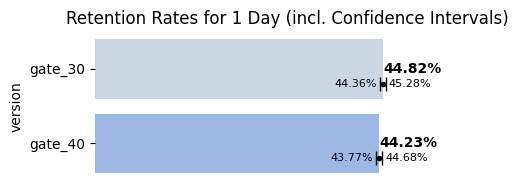

In [29]:
sys.path.append(os.path.abspath(".."))
from custom_modules.plot_formatting import horizontal_bars_estimates_ci

plt.figure(figsize=(5, 2))
sns.barplot(
    x="retention_rate",
    y="version",
    data=retention_rate_1,
    alpha=0.7,
    palette=["lightsteelblue", "cornflowerblue"],
)

horizontal_bars_estimates_ci(retention_rate_1, "retention_rate")

plt.title("Retention Rates for 1 Day (incl. Confidence Intervals)")
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.xlabel("")
plt.xticks([])
plt.xlim(0, 0.6)
plt.tight_layout()
plt.show()

In contrast, the results of the **Day 7 retention rate** indicate a statistically significant difference in retention rates between the control and experimental groups. The experimental group had a significantly lower Day 7 retention rate at only 18.20%, suggesting it was less successful in retaining users compared to the control group (see below). However, the minimal effect size suggests that this difference of 0.8 percentage points lacks practical significance.

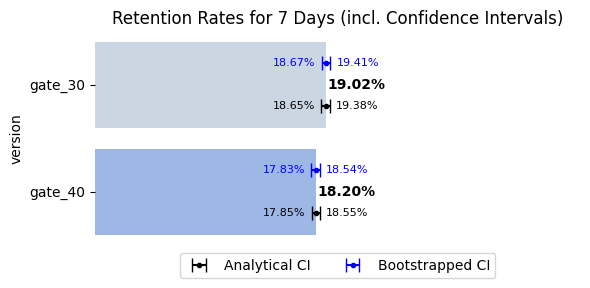

In [30]:
sys.path.append(os.path.abspath(".."))
from custom_modules.plot_formatting import horizontal_bars_estimates_2cis

plt.figure(figsize=(6, 3))
sns.barplot(
    x="retention_rate",
    y="version",
    data=retention_rate_7,
    alpha=0.7,
    palette=["lightsteelblue", "cornflowerblue"],
)

horizontal_bars_estimates_2cis(retention_rate_7, "retention_rate")

plt.title("Retention Rates for 7 Days (incl. Confidence Intervals)")
plt.legend(loc="center", bbox_to_anchor=(0.5, -0.1), ncol=2)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.xlabel("")
plt.xticks([])
plt.xlim(0, 0.4)
plt.tight_layout()
plt.show()

*Additional task:* From the plot above we can also see that both, the analytical and bootstrapped approach of calculating the Confidence interval come to a very similar result.

Due to the failed sanity check, we are unable to provide data-driven decision recommendations.